In [1]:
%matplotlib notebook

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation
import IPython
import IPython.display
import IPython.core.display
from os.path import join, exists
from os import makedirs

output_dir = '../../outf/HW2-4'
if not exists(output_dir):
    makedirs(output_dir)

In [2]:
def make_animation(plotx, E, xl=(0, 1), yl=(0, 1), inter=25, display=False):
    '''
    takes a graph and motion of vertexes in 2D and returns an animation
    E: list of edges (each edge is a pair of vertexes)
    plotx: a matrix of states ordered as (x1, y1, x2, y2, ..., xn, yn) in the rows and time in columns
    xl and yl define the display boundaries of the graph
    inter is the interval between each point in ms
    '''
    fig = mpl.figure.Figure()
    mpl.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=xl, ylim=yl)
    ax.grid()

    list_of_lines = []
    for i in E: #add as many lines as there are edges
        line, = ax.plot([], [], 'o-', lw=2)
        list_of_lines.append(line)

    def animate(i):
        for e in range(len(E)):
            vx1 = plotx[2*(E[e][0]-1),i]
            vy1 = plotx[2*(E[e][0]-1)+1,i]
            vx2 = plotx[2*(E[e][1]-1),i]
            vy2 = plotx[2*(E[e][1]-1)+1,i]
            list_of_lines[e].set_data([vx1,vx2],[vy1,vy2])
        return list_of_lines

    def init():
        return animate(0)

    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=inter, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    if(display==True):
        IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))
    return ani

In [3]:
class SecondOrderControl:
    def __init__(self, G, poses, zref, time=15, dt=0.01, k=0.5):
        self.G = G
        self.zref = zref
        self.time = time
        self.dt = dt
        self.k = k
        self.N = G.number_of_nodes()

        self.T = int(time / dt)
        self.u = np.zeros((self.T, self.N, 2))
        self.x = np.zeros((self.T, self.N, 2))
        self.x[0] = poses

        self.L = nx.laplacian_matrix(G).toarray()
        self.D = nx.incidence_matrix(G, oriented=True).toarray()

    def draw_initial_conditions(self):
        pos = {}
        plt.figure()
        for i, position in enumerate(self.x[0]):
            pos[i+1] = position
        pos_shadow = {key: (value[0] + 0.005, value[1] + 0.005) for key, value in pos.items()}
        nx.draw(self.G, pos_shadow, with_labels=False, node_size=600, node_color='none', edgecolors='gray', edge_color='gray', width=3.0, alpha=0.5)

        nx.draw(self.G, pos, with_labels=True, node_size=600, edge_color='red', width=2.0, linewidths=3.0, edgecolors='black', node_color='white', font_size=12, font_weight='bold')
        plt.title('Initial Conditions')
        plt.show()

    def run_simulation(self):
        for t in range(1, self.T):
            self.u[t - 1] = -self.k * self.L @ self.x[t - 1] + self.k * self.D @ self.zref
            self.x[t] = self.x[t - 1] + self.u[t - 1] * self.dt

    def plot_results(self, filename=None, display=True):
        E = list(self.G.edges())
        X = np.zeros((2 * self.N, self.T))
        for i in range(self.T):
            for j in range(self.N):
                X[2 * j, i] = self.x[i, j, 0]
                X[2 * j + 1, i] = self.x[i, j, 1]

        ani = make_animation(X, E, xl=(0, 5), yl=(0, 5), inter=10, display=display)
        if filename:
            writervideo = animation.FFMpegWriter(fps=20, codec='h264', extra_args=['-pix_fmt', 'yuv420p'])
            ani.save(filename, writer=writervideo)

        return ani

## Incomplete Graph

<IPython.core.display.Javascript object>


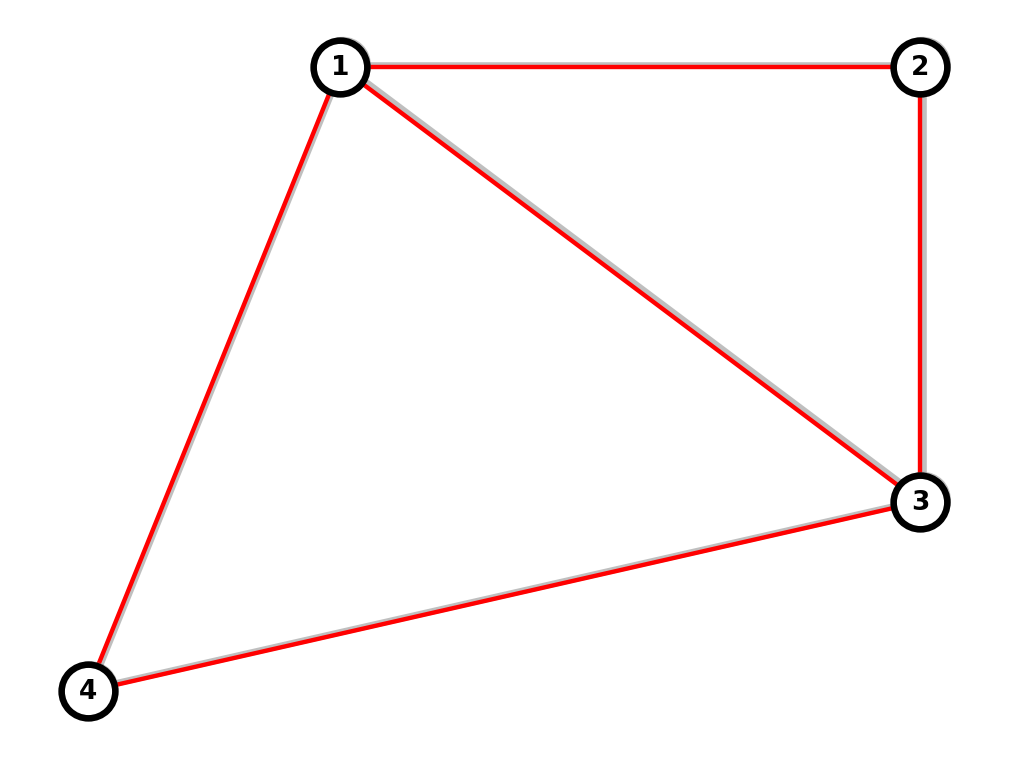

In [9]:
N = 4
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])
G.add_edges_from([(1, 2), (2, 3), (1, 3), (1, 4), (3, 4)])
a=7/2-np.sqrt(7/8)
poses=np.array([[3,4],[4,4],[4,3],[a,a]])
zref = np.array([[1, 1],[1, 1], [np.sqrt(2), np.sqrt(2)], [1.5, 1.5],  [1.5, 1.5]])

control = SecondOrderControl(G, poses,zref)
control.draw_initial_conditions()

## Simulation under Random Initial Condition

In [7]:
poses=np.random.uniform(0,5,(N, 2))
control = SecondOrderControl(G, poses,zref)
control.run_simulation()
control.plot_results(filename=join(output_dir,'simulations_animation.gif'))

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABj3ptZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EIdliIQAf/70o/gU0ZZMMN+XJS/SOQsOSlFwi/jx0AAAAwAAAwAABxUsbP22eumt4AAAD0AEnziC
3DAgDI7JECAIsAD1tm7Oyg8TnP1mDVBVSZ9vGsaPwSyjuqFSRL+EG/+FwornVzSAL5OzDRwsBklq
B83ii4uAkwiSY/9fRy/6DMS+wuhR6L896qlPfvVf9CdTN6azougEI3VcfKk/+drUygdwhNRYi2DN
LRHs75b9+9qrRRktQeYe7GPDn2mBwq6EaiNCHOhKSe6PPjT1GTXji8KMuF//41JPYO/A0WXRZ0mN
lS4PMpW5rN3QJ+GwDzQOIisD+FseXPE3TlXQ2fuvPfHDPLec6+nkx2CjU+z//Km8LldQq1CudD+i
kIbKa7Lix4c7Y/sk+PEJYABktPmZ+Nevc1sIVHKgd3pow+VrvI+1oASfu8S1eslzA/zOiUQ82ARC
HKHdVKN6zsNrTiZOlH3gOAIICw2xPYkunoNQWpHkXK1vOBGqfXINFfTcK/8WaXAC+WhKvZNXTaqz
Vqqwzba/4SJRNrVjxbm1+ajmLcn0FXSvQqygqQMP5eu16/uoh8RJBGVtol8FgibjuDygVQ3cn6s3
YWxrF0cHPV3cZ4icjvhQ2//zH7JAN9IfIWA/R3/vOWwRKZI/hHLY8ArheX3NK5HlQwMdtXHF+0Wp
JbgTD5T+rEQDfyPlfDWY6LV6pyGDKyrJrS76Evqo9eV58swVGceqgzcY/nJFB9ZSWLk+jgJF5sL3
pWZBdGrdvnMfd+GRWxY5sSQS7pnuO6TwB+h05uqiS2xDG6rYX9EZdGDkQqNXKOTbUDEPzifs4dQB
Yc/sa+iCW17DhqqehQ/Ye2oOFNOS9EbizxwxzLJNb1ufYv9TA80ra6EJD1I00zY6siNSO2I2XHaG
jjUrK/B1bVJ6KtTb2S7YqvsBnmHsC6UEq6ltX7WXmwAUQanSwYmpsX2MgZRGwlqzHQL+GIwAlmeP
4godeaix5oHF+Wunb0eUGi8xFTSs4oZtvI4sO+zmLMILQTjKamLAWzaoMZCJXVADt9x6hLbsuIOw
ytZG/9o+wCsxI95Gmj9DVvwoXVAcfAoHwRchXKjw8tlz+axICI+tJL/mnXgz1AQjQLMrKPfcoAGu
QYBGU2/kNjyZFDD3wxukT/658mzNA6qIlNwz2TmFUbcitZpdKFTZoVprkUImz/pk13E4XyINhkoo
Ois6P9q9mGBi8WwYAB2SKEHfnLgkiMeNq1lRGENrzTMT1Hqr35E9AjrnnO9KyoxIPodt116fMapU
3G5hGw1oLRX+CJ2GFjpHqS1cs/OjA2jG7uKOz6QQ/Riu529AMV1/W7BQR1Jp8mr0qQu3xkRMWcz/
/xfHPBf4GE7LLcLfIkfQJYtAqbTEa3N4YQmQfjKwwr9K/ir4Id7KSxltFBTDbcomRmB2cGXH3GiZ
5EaYb/b6kxIZSbpzuCOZVZfoaeGDIqy2TTKteAiJcKvya+kC7hpVWA6kEvO1nYMoFSBowx9tIw1w
+V54BLGf9zECJtU5g8So6gccNyTLEC6DkTfdm4qjO7wUjpklC89uOSOpqcF/upjYhW3sGBI7/O0O
vjc7nb2qEzWxHEDtptcVr1QoGYiCZjYg7z0qYh7SbGZo8CYR66yjsUqCyyTG06vxV4LVcCKp4buA
545LCH5Zp9vci7moO0cIu1iHtHMKyJPkSqUE05RveV/+sXELYZigVmJLxR0BKiU1lOpWnItptpYG
L6FmezfxHwJhUAKpNLlXiEfN5gfSsd10KaJ1+R8OfGeZ98e3h0JfNVhKK1vNky2viDTS+B322UBY
P1k6m5wHKpviXI958AD5C8PPYVJkZWr5qMvjtfHJPYjaDOsTd/lvWxJ9ZcuqP/7WD5A4c22frUTu
kHKiAcz8mZ6DppylL077uAsabzNhsKXMHCHAj+Xq4fPnrsIR9L6H8k3qCoD2TirIQsBRMN8fpPSv
dSy6IZm+ppcuRNs3HBlIru1JeXxwRCSVnSiIgcNpCDSg2gR6WPMv4WcnZCEIVe16Cs6Kndbo+miV
vE/uZkwBIRkKsMnCQXfbfVVwMt6DE8tTlMA5YgO0J9ggPwIRhd76pdqN609hnJ3C8K47b4SHRD8T
kul5VgqIxPF/LwpGf/NlMx9P2laGh6oeWH5Lcqy18wx3/w05hrmmpvJvZXZaiS6VrtQj0uXk9Pui
eH8+1gxeHI5WlVC3ZSG0Df9YkgpklYNn/Ezm7LcItbNYVZ8k+ngpw0lAVnCqcyd6c7jsWkdhi3H/
7WqpZhIZB/D3E++Z1QomP//9bCWAtBHDQAv/6dIFUo527todtanCf8oS5CS7RJAXejFfbNK1zUZS
w3mnA8Ce7pURZNxsQwCzdYCdIYMtySPYpDjpuWh0ZEmUILDFLLxpzzkHU8r6LZU+rXAXjvmMbi/p
VgMexk5di3ecQQ1e8DvjcPxE8L0S2j86UlNxilM9nC/+d6+dv3ospQdMFd66Bqt/f6GfSUhP4cae
tYhNwwPRMfyt/3aojq0LTrE3fl/vmP/OCd2wOh1D5EVyNbp/zPuCUoHUIINv//g7sA6T80lGf+gR
+y+joNZYNdjNFcZb8J9aJtkcxSGZpmBdu7tmibhb92sy0DSwg0miaUaMj0FOg3b4c37E4BgcyXEz
nv0GtcTi2EoD80t5eRIdGfVmx6+VAD58fsn3lQssKfk/tyab46CrXXTuIcEOR+VbmD3nZf5PJXcE
c++vzoBUxGjQ+J1Sr3vX5YNRoc40XKjplldzLOG6XMSXQ8spfSfQkASDr0s7O7OOhbrwfst8M6xO
Vh6plMNCqsVKhsur+yVXx2CLZ1DaUgdk8hfzGQPJHHqTNpZm0gQqsyl/5xH/oHmzGX/4Nra3i3De
e7Vv1CvBPJfGG/fao64CM

## Complete graph

<IPython.core.display.Javascript object>


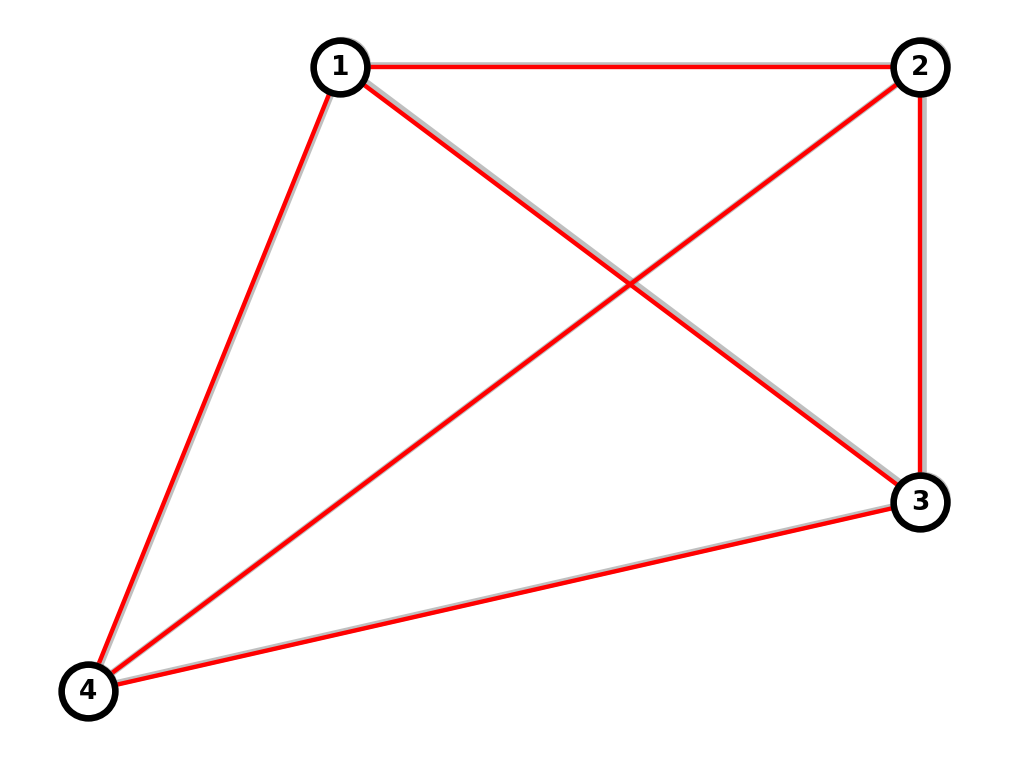

In [10]:
N = 4
G_new = nx.Graph()
G_new.add_nodes_from([1, 2, 3, 4])
G_new.add_edges_from([(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)])
b=np.sqrt(7/4)+np.sqrt(1/2)
zref_new = np.array([[1, 1], [np.sqrt(2), np.sqrt(2)], [1.5, 1.5], [1, 1], [b, b], [1.5, 1.5]])
a=7/2-np.sqrt(7/8)
poses=np.array([[3,4],[4,4],[4,3],[a,a]])
control_new = SecondOrderControl(G_new,poses, zref_new)
control_new.draw_initial_conditions()

# Simulation under Random Initial Condition

In [8]:
pose=np.random.uniform(0,5,(N, 2))
control_new = SecondOrderControl(G_new,poses, zref_new)
control_new.run_simulation()
control_new.plot_results(filename=join(output_dir,'simulations_animation_complete.gif'))

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABY6BtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE1
IGxvb2thaGVhZF90aHJlYWRzPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
EK1liIQAX/7yK/ApnClWwXcE/95SqYYGRT65kWsYAAADAAADAHOgAAGIgGDvjULyCXAE9UpXBtOz
nCf4b+TIII5zGeQ6Vde1Je7JXqR5aVbEHSOyPD+IFN9YngppAF8nZKkEtadfygeFHhUXLZMIexMA
7KOvXTKDsT3oUehhX1FUp593//QnUzeMhGVh2s1AQx3Rk4ZOle2SwN81gZWOWXqdPazdGTuJEbUA
qbEUfsOYTYiqHYKCBzjtRKEEAmRaRRXz5/8gRHex/Gnd8ADsPPQv2ED/JC7UGXQgaxFV8U9tTU3s
M2SQALm7oE/DYB3Wuw3/XKsbID4GoQtmVmfgryyuv0Pwpr1KDtKZjFG6naUCAHAiIPDRuZ+XNxNl
Z0GVQApZWHVRoJ2foHIP1jKvNKrLTBokL1rpJ5tJGprrJ/CdOkH43fKIw4pAmBKmqyG3IiyYeOIQ
PKlidJGYZn3FvejfnIPO0SIbN7b3gRJxW1FeGSez4nGAIy6LVrFheb3wTY1PswstyjsVAYjQPTgN
jaBaJrG1OaF4rnvgVWs8FNKt5ukK5Mg1MaenHAW5NocM3WOUKf/xZZ5Tf/ipf/w0cYYYlGEHNy3Q
5GEklbF1JDp0JkNkWTYTojnLtmP21E5CXHC0v907UhiD8yAqY91PpQYk+4+kfWaeRgAbodpCjfI4
3D95yfj9lJzg/VBJ64I4rzXxzwXnRL6FsNLFl2Pj8uY247txbrFTS83R5a/YRXA3IQH9JZSlyrUf
i73RBItPTLUmUg+QGrQNyzyRB/h0Vjy1qMkCM4KTtfj/x+zLlDV3QAfUAv6mARSqJr4eaDgxZrRA
Y6ipSGSskxoP1ryv9MGK0qr6kYFBOHJ7MYQM0SSmxRl3sxOv2aAwGJsdzoWI90dSdp+1TtJMHT7n
628qWuCE89kKeoqW6ut0CImrItbIvMqc5UP03e2N+c7o2kDHW9/ACDcx5hZ/DYgEBIvHYEukYg+O
Lmbaa+VoTCi5TnKIEXSfi4yi9tdDvqpojhNk02N4HrRu6LxkKnv5LjI+qjd+n9L23fUn8neVVo8d
t4miE9vaxxX4kQaqGfQn3fZYOjToC7EZembwB3oqkm0c4Ch1q+UqJJUWnwGauC3x4YZWo9Zg0O0a
aUDiKip9LYz4sCWZFQyDtp1y3/v6h4vNrFSDk5d5qhWDz1wRnf0gZk5eFkUsyMteKlN3ZZ443aJb
ruNvyaYft6HCO5c4vuHPUnMW3xci383LBHI3kLc20OckrFHI5S8bdxbq5eeZzOEh11Ixe9WBvrdT
Ndb8Hvka0MU4IJ/U37PKlhYByTDYmlvYaxxlDtOqvFNF9lNHEloDyAjSek5LcoXg4OXbZkT9OgvS
Fpbm+7YfrXlgiNKR+C8sb2dGoSVX+lJYwFOMwiu2K6qTwDVvkUJMbXxsgL4OOrEXWgHeQ89YXEkO
idMOVl6jgJ/aNe0L93La/DOvG4Uu5hEm8kUm7mhq85xrmuNES3e2nw1ZprkwWfGhKSff748+CYo1
/0MvBgy0vRtCa5Nqr6BBUL8u3hZSqzbkp+rmzbBHDL12aSdAvFbYunrCWZrfRIAF/3kSXKWHADE5
ZtXNtPXVxbfM0gcoS4k+zM4c3CywzA3sDJWq9k3kVoYw+ieWsTvff0m5aQJVJLwyAK2uqWPsUzeN
VoC0ih+FSHIEVP9hTO555ZyM5Mv+FnULYpn34tiKBpD24mO64NXeMoDQINKZfjA1bMwAGHCrVf1u
caJPISbRyPGu5QGfzkrDD6vZDQha1SAGJB9RIuL3ZsPAI3M7tV2nfAkDAf8ugFvtfxYqXg5aPxLJ
cFbeux15mj12ID7/MLtxjxqMRmXufum9b1tmO274C1b78mZaLET+sOX2ABLMJw0gb2u5DGdq65ju
jFD0oWvrv64+RtNkOToYaM/yt+ev79qYVJ0jJPGL7JcYHNR35DAnNVr8FJA31FHQrpp2ONkZGYvQ
dUTvOauH+segSwh8CCkiQySSBbagFT/RXrsHvCH0Pbh5Jc8eVBb79w5p/Q2BZJelQONVzr+VMzit
AvLgqzioVgysSbbiv/hiNMgzZAwAmkgRToZWTn33PsePQ+MYPBsOWWZq42x3UnbnTawUEy822Yxr
+WwzWjA/Xb9iT5fWNqWp56VhSDL/MPoFAnUtOK9zUflKZu+fPgFTN6IB+zXoefs3izqK3S+lNToj
iUMqweqqFd6TkftFmotswohfAaNBvUcxszXgE9syw2eJ1T4RkSV4jrZXwSwf5bJ02CZP84GlXOry
/3jBhpXTkKAoxDpbQaWOscfW4ZRx68byynZ2BQNVo+QW0d2whoPi2ZwrT2Y5YZ8X83iCsNIHPH9N
W9sc/nYJwd9Jn/KJQCuVA7067ST/t+LZZHboFA8xDUz9Girl9MnQWZOn8nFG9WhJ+KsZTy/m0eSu
AhaSiuAxy0QpV4Vfi41iGvB95MeDl/0yNm/jGOvJiqW+LfR5Tx/c3a1LvgXgCc7pUeAZhOrQGFbJ
eDhIzCsBrnKmuY3FDnU3X5Ap4SUfpLzmcey0bzxZOceMq9DR/jQ+jSR0n4L/ilWWtWjpLckh0Tx3
NvZcDGM2KcvgBvwn9uDD70npuo+UUH2Mkl2U1qZDjMfMUhvbQRgAW5auN14ZUyqnNINWKFrjG9cY
WHUPY38TCdeQneKGOqxJbVBrGxbiWVA5drtxJkf8pAxeYzlQpZgh9gTaTtzKJ+XIGAPKgPHtNbJB
ntpPs27X3iZBsdMP/qlNSAcriO9T7mPxRFIDfn7zEZHlDW559aHrmNQ1pmaGbwbZIc/s/sTXu1OY
fWU5Bx3551Fae2FB27vmXVCq/i/G/S2heqf96RT4cPZ3T9cyRzO6Z1if/NkRBQfvMYBCkslC2Cio
DRt/hMMUXWmGoUTxzaKKe